***
# CSCA 5642 Final: Diabetic Retinopathy CNN
***

This project is about predicting the stages of diabetic retinopathy in patients via pictures of their eyes. It a multi-class classification problem, and I will be training a deep learning model.

Diabetic retinopathy is a condition where blood vessels in the eyes are damaged from high blood sugar levels caused by diabetes, causing loss of vision. Identifying the stages of diabetic retinopathy accurately could potentially help many people save their vision, without needing to resort to more expensive treatments that may not be necessary.

This project will build a Convolutional Neural Network (CNN) to predict 5 stages of diabetic retinopathy, including when there is none. CNNs use many filters to combine and transform the data of an image in small pieces, and combines that information into larger pieces. These convolution layers are able to identify small and large patterns in the data, allowing it to learn more complex conditions.

The data is from [this Kaggle dataset](https://www.kaggle.com/datasets/jockeroika/diabetic-retinopathy/data), and contains 1986 images of people's retinas. The images are 256x256px, and use 3 color channels. They are all in .png format. The 5 classifications in this dataset include: Healthy, Mild DR, Moderate DR, Proliferate DR, and Severe DR. My model will attempt to predict which of these 5 categories any given retina scan belongs to.

### Imports

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
import glob
import os
from collections import Counter
import json

%matplotlib inline

***
# Data Exploration and Cleaning
***

## Exploration


Class distribution:
  Healthy: 525 images (26.4%)
  Mild DR: 370 images (18.6%)
  Moderate DR: 599 images (30.2%)
  Proliferate DR: 290 images (14.6%)
  Severe DR: 202 images (10.2%)

Total images: 1986
Average images per class: 397.2
Class imbalance ratio: 2.97:1


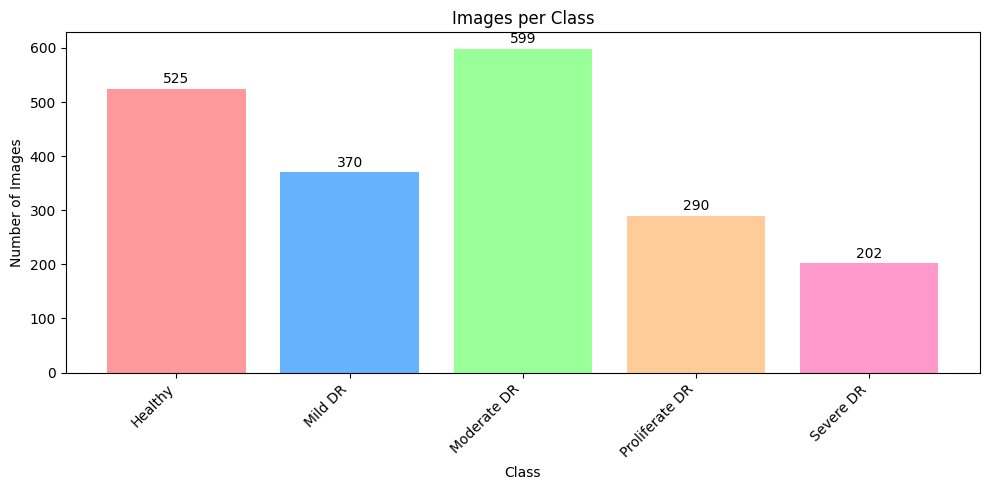

In [19]:
data_dir = 'data'
classes = os.listdir(data_dir)

class_counts = {}
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if f.endswith('.png')]
        class_counts[class_name] = len(image_files)

print("\nClass distribution:")
total_images = sum(class_counts.values())
for class_name, count in class_counts.items():
    percentage = (count / total_images) * 100
    print(f"  {class_name}: {count} images ({percentage:.1f}%)")

print(f"\nTotal images: {total_images}")
print(f"Average images per class: {total_images / len(classes):.1f}")

max_count = max(class_counts.values())
min_count = min(class_counts.values())
imbalance_ratio = max_count / min_count
print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1")

plt.figure(figsize=(10, 5))

classes_sorted = sorted(class_counts.keys())
counts = [class_counts[cls] for cls in classes_sorted]
bars = plt.bar(range(len(classes_sorted)), counts, color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC'])
plt.title('Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(range(len(classes_sorted)), classes_sorted, rotation=45, ha='right')

for i, v in enumerate(counts):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

At first glance, there is a significant class imbalance. There are more samples towards the healthy side of the scale rather than the severe side. The training step will need to change the weights of the classes..

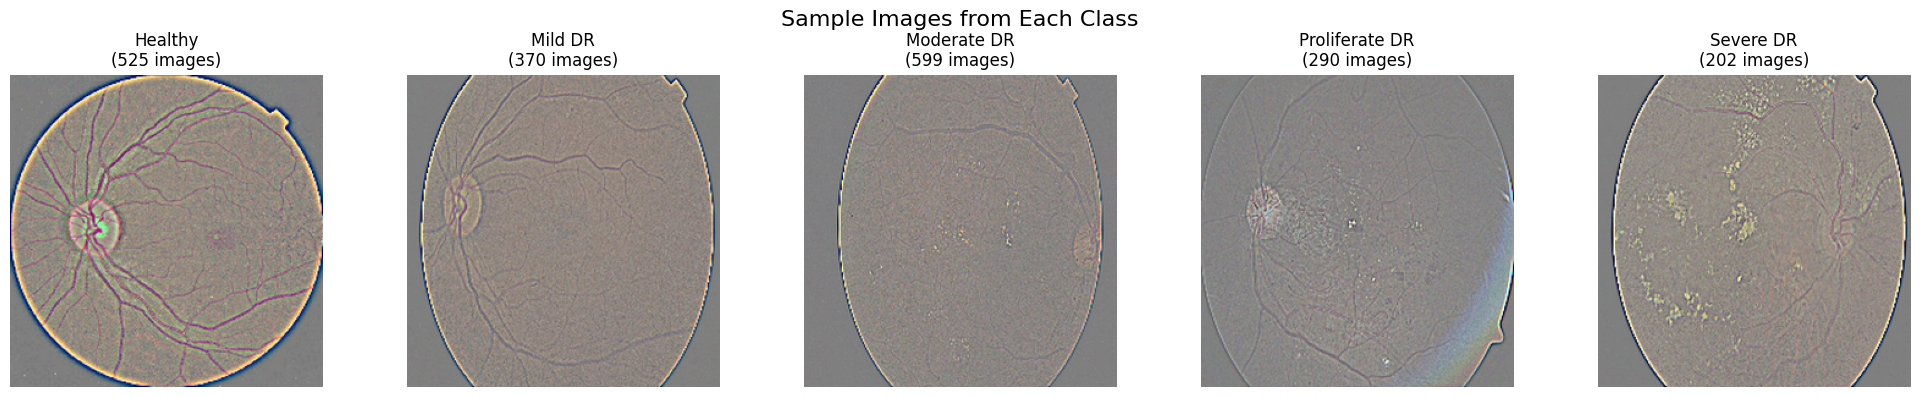

In [20]:
fig, axes = plt.subplots(1, len(classes), figsize=(20, 4))
fig.suptitle('Sample Images from Each Class', fontsize=16)

for i, class_name in enumerate(sorted(classes)):
    class_path = os.path.join(data_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith('.png')]
    
    if image_files:
        sample_path = os.path.join(class_path, image_files[0])
        img = Image.open(sample_path)
        
        axes[i].imshow(img)
        axes[i].set_title(f'{class_name}\n({len(image_files)} images)')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

consistent_size = True
dimensions = set()
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith('.png')][:5]  # Check first 5 from each class
    
    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path)
        dimensions.add(img.size)

The images seem to have low color intesity and contrast. While the images are all the same size and format, some of the scans seem to be squeezed or rotated in different ways. The data will have to be augmented to help make the data more consistently random, in order to make the model more general.

Higher levels of DR also have clear visual artifacts showing as yellow marks on the eyes, and they are also unlike any other patterns on the eyes. This will likely help the model become more accurate.

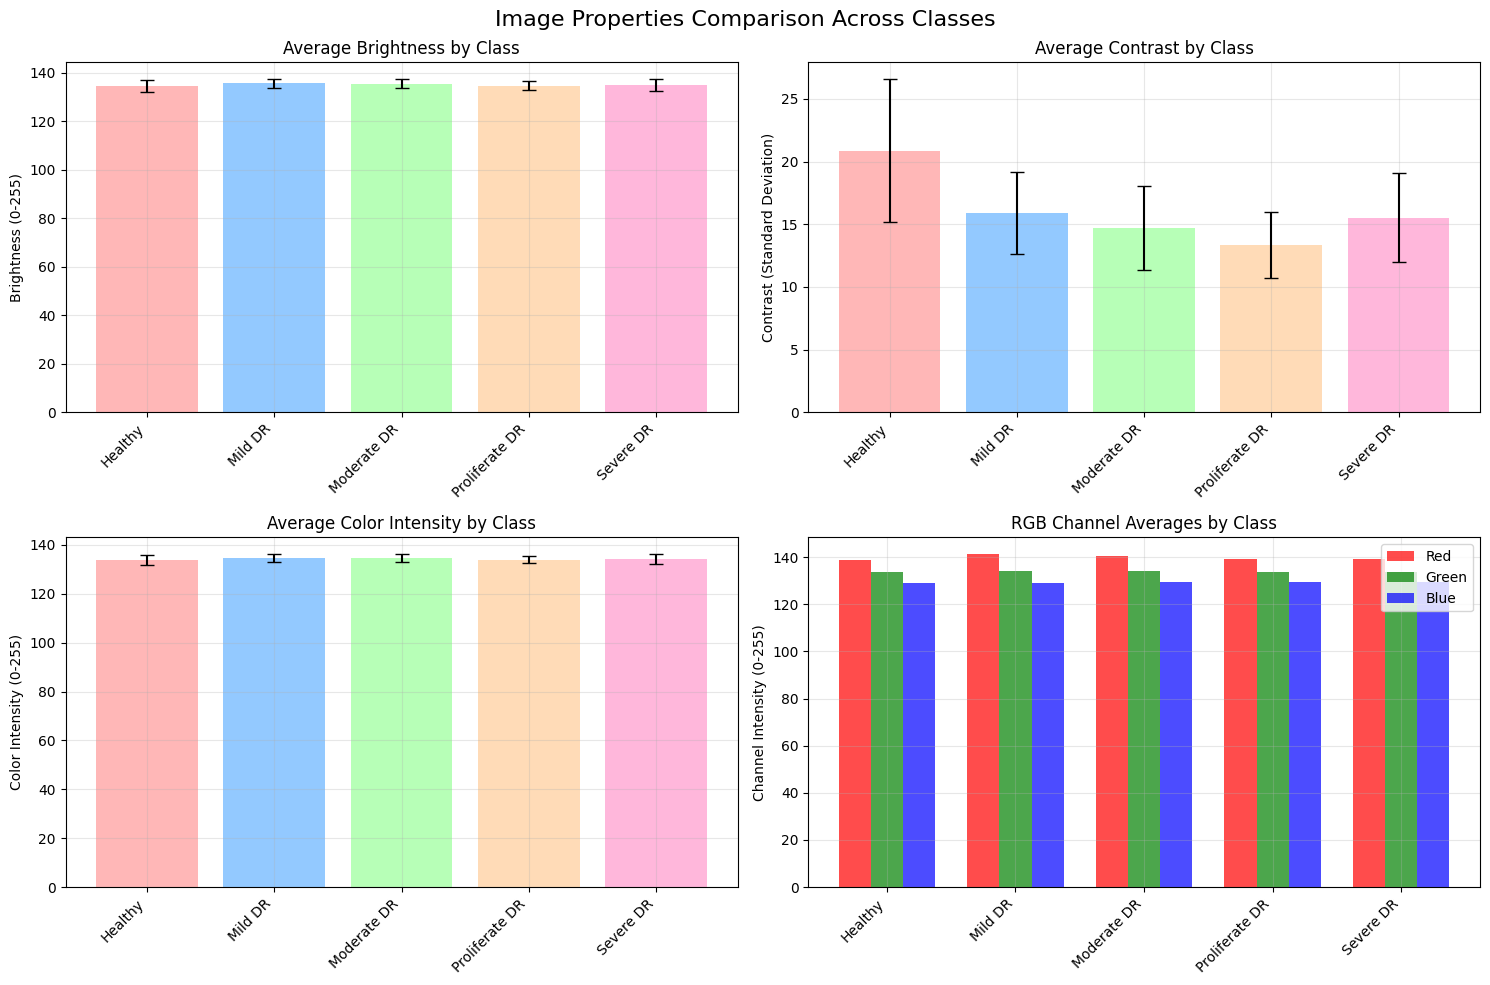

In [21]:
def analyze_image_properties(image_path):
    img = Image.open(image_path)
    img_array = np.array(img)
    
    gray = 0.299 * img_array[:,:,0] + 0.587 * img_array[:,:,1] + 0.114 * img_array[:,:,2]
    
    brightness = np.mean(gray)
    contrast = np.std(gray)
    r_mean = np.mean(img_array[:,:,0])
    g_mean = np.mean(img_array[:,:,1])
    b_mean = np.mean(img_array[:,:,2])
    color_intensity = np.mean(img_array)
    
    return {
        'brightness': brightness,
        'contrast': contrast,
        'red_mean': r_mean,
        'green_mean': g_mean,
        'blue_mean': b_mean,
        'color_intensity': color_intensity
    }

class_properties = {}
sample_size = 20

for class_name in sorted(classes):
    class_path = os.path.join(data_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith('.png')][:sample_size]
    
    properties = {
        'brightness': [],
        'contrast': [],
        'red_mean': [],
        'green_mean': [],
        'blue_mean': [],
        'color_intensity': []
    }
    
    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)
        img_props = analyze_image_properties(img_path)
        
        for key in properties:
            properties[key].append(img_props[key])
    
    class_properties[class_name] = {
        key: np.mean(values) for key, values in properties.items()
    }
    class_properties[class_name].update({
        key + '_std': np.std(values) for key, values in properties.items()
    })

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Image Properties Comparison Across Classes', fontsize=16)

class_names = sorted(class_properties.keys())
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC']

brightness_means = [class_properties[cls]['brightness'] for cls in class_names]
brightness_stds = [class_properties[cls]['brightness_std'] for cls in class_names]
axes[0,0].bar(range(len(class_names)), brightness_means, yerr=brightness_stds, 
              color=colors, alpha=0.7, capsize=5)
axes[0,0].set_title('Average Brightness by Class')
axes[0,0].set_ylabel('Brightness (0-255)')
axes[0,0].set_xticks(range(len(class_names)))
axes[0,0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0,0].grid(True, alpha=0.3)

contrast_means = [class_properties[cls]['contrast'] for cls in class_names]
contrast_stds = [class_properties[cls]['contrast_std'] for cls in class_names]
axes[0,1].bar(range(len(class_names)), contrast_means, yerr=contrast_stds, 
              color=colors, alpha=0.7, capsize=5)
axes[0,1].set_title('Average Contrast by Class')
axes[0,1].set_ylabel('Contrast (Standard Deviation)')
axes[0,1].set_xticks(range(len(class_names)))
axes[0,1].set_xticklabels(class_names, rotation=45, ha='right')
axes[0,1].grid(True, alpha=0.3)

color_intensity_means = [class_properties[cls]['color_intensity'] for cls in class_names]
color_intensity_stds = [class_properties[cls]['color_intensity_std'] for cls in class_names]
axes[1,0].bar(range(len(class_names)), color_intensity_means, yerr=color_intensity_stds, 
              color=colors, alpha=0.7, capsize=5)
axes[1,0].set_title('Average Color Intensity by Class')
axes[1,0].set_ylabel('Color Intensity (0-255)')
axes[1,0].set_xticks(range(len(class_names)))
axes[1,0].set_xticklabels(class_names, rotation=45, ha='right')
axes[1,0].grid(True, alpha=0.3)

x = np.arange(len(class_names))
width = 0.25
r_means = [class_properties[cls]['red_mean'] for cls in class_names]
g_means = [class_properties[cls]['green_mean'] for cls in class_names]
b_means = [class_properties[cls]['blue_mean'] for cls in class_names]

axes[1,1].bar(x - width, r_means, width, label='Red', color='red', alpha=0.7)
axes[1,1].bar(x, g_means, width, label='Green', color='green', alpha=0.7)
axes[1,1].bar(x + width, b_means, width, label='Blue', color='blue', alpha=0.7)
axes[1,1].set_title('RGB Channel Averages by Class')
axes[1,1].set_ylabel('Channel Intensity (0-255)')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Brightness, color intensity, and RGB values seem to be fairly equal among the classes. The average contrast shows the biggest difference between classes, with a U-shape in the plot. Healthy and Severe DR scans have the highest average contrast, and Proliferate DR has the lowest.

These color properties will be normalized in the preprocessing step. Without normalization, higher or lower values in certain parts of the images can end up dominating the gradient calculations, leading to worse results.

## Preprocessing

The following code deals with the class imbalance and image inconsistency issues.

Class weights are calculated based off of their size proportional to the size of the total data set. These weights will be passed into the model.fit() function.

The data is augmented in several ways to promote randomness of data and prevent overfitting on this particular dataset. There are random rotations, zooms, changes in contrast, brightness, movements (translations), and horizontal flips. These augments reflect the variations that real retina scans may have, which helps make this dataset more general.

In [22]:
IMG_SIZE = (256, 256)

healthy_paths = glob.glob('data/Healthy/*.png')
mild_paths = glob.glob('data/Mild DR/*.png')
moderate_paths = glob.glob('data/Moderate DR/*.png')
proliferate_paths = glob.glob('data/Proliferate DR/*.png')
severe_paths = glob.glob('data/Severe DR/*.png')

healthy_labels = [0] * len(healthy_paths)
mild_labels = [1] * len(mild_paths)
moderate_labels = [2] * len(moderate_paths)
proliferate_labels = [3] * len(proliferate_paths)
severe_labels = [4] * len(severe_paths)

all_paths = healthy_paths + mild_paths + moderate_paths + proliferate_paths + severe_paths
all_labels = healthy_labels + mild_labels + moderate_labels + proliferate_labels + severe_labels

dataset = tf.data.Dataset.from_tensor_slices((all_paths, all_labels))

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),           # 72 degrees
    tf.keras.layers.RandomZoom(0.2),               # 20% zoom  
    tf.keras.layers.RandomFlip("horizontal"),      # horizontal flip
    tf.keras.layers.RandomContrast(0.2),           # 20% contrast
    tf.keras.layers.RandomBrightness(0.2),         # 20% brightness
    tf.keras.layers.RandomTranslation(0.1, 0.1),   # 10% translation
])

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    img = (tf.cast(img, tf.float32)) / 127.5 - 1.0  # normalize to [-1, 1]
    return img, label

def load_image_with_augmentation(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    img = (tf.cast(img, tf.float32)) / 127.5 - 1.0
    
    img = data_augmentation(img, training=True)
    return img, label

The data is also batch loaded for memory efficiency.

In [23]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

train_data = (train_dataset
              .map(load_image_with_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .shuffle(BUFFER_SIZE)
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))

# not augmenting validation data for better real world accuracy
val_data = (val_dataset
            .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

# 0: Healthy, 1: Mild, 2: Moderate, 3: Proliferate, 4: Severe
def convert_to_categorical(image, label):
    return image, tf.keras.utils.to_categorical(label, 5)

train_data = train_data.map(convert_to_categorical)
val_data = val_data.map(convert_to_categorical)

Training samples: 1588
Validation samples: 398


In [24]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class weights:")
class_names = ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']
for i, name in enumerate(class_names):
    print(f"{name}: {class_weight_dict[i]:.3f}")

Class weights:
Healthy: 0.757
Mild DR: 1.074
Moderate DR: 0.663
Proliferate DR: 1.370
Severe DR: 1.966


## Plan of Analysis

The goal of this model is to be able to predict what stage of diabetic retinopathy a patient may be at, and thus inform their healthcare team what level of treatment they may need. Both over and undertreatment are very undesireable, as they can either cause permanent vision loss (undertreatment) or excessive discomfort cost to the patient (overtreatment).

This means both precision and recall are very important for this model. That is why I will mainly be using a weighted F1 score to measure the performance of the iterations. The F1 score takes into account the harmonic mean between precision and recall, and the weighted version weights precision and recall by the class imbalanaces. Each class has their own F1 score calculated, and then these are averaged by the class weights.

In [25]:
# Custom weighted F1 score metric
@tf.function
def weighted_f1(y_true, y_pred):
    # Convert predictions to class predictions
    y_pred_classes = tf.argmax(y_pred, axis=1)
    y_true_classes = tf.argmax(y_true, axis=1)
    
    # Calculate per-class F1 scores
    num_classes = tf.shape(y_pred)[1]
    f1_scores = []
    class_weights = []
    
    for i in range(5):  # We have 5 classes
        # True positives, false positives, false negatives
        tp = tf.reduce_sum(tf.cast(tf.logical_and(y_true_classes == i, y_pred_classes == i), tf.float32))
        fp = tf.reduce_sum(tf.cast(tf.logical_and(y_true_classes != i, y_pred_classes == i), tf.float32))
        fn = tf.reduce_sum(tf.cast(tf.logical_and(y_true_classes == i, y_pred_classes != i), tf.float32))
        
        # Calculate precision and recall
        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())
        
        # Calculate F1 score
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        
        # Weight by class frequency
        class_count = tf.reduce_sum(tf.cast(y_true_classes == i, tf.float32))
        
        f1_scores.append(f1 * class_count)
        class_weights.append(class_count)
    
    # Calculate weighted average
    total_weight = tf.reduce_sum(class_weights)
    weighted_f1 = tf.reduce_sum(f1_scores) / (total_weight + tf.keras.backend.epsilon())
    
    return weighted_f1

***
# Modelling
***

> *Note: the training of the models was done in Google Colab, so the actual outputs aren't here. The history data is loaded from json files and plotted.*

### Functions

In [26]:
EPOCHS = 50
hists = []

In [27]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    epochs = range(1, len(history['loss']) + 1)
    
    # loss
    axes[0].plot(history['loss'], label='Training Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticks(epochs)
    
    # accuracy
    axes[1].plot(history['accuracy'], label='Training Accuracy')
    axes[1].plot(history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Model Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xticks(epochs)
    
    # weighted f1
    axes[2].plot(epochs, history['weighted_f1'], label='Training', color='blue', linewidth=2)
    axes[2].plot(epochs, history['val_weighted_f1'], label='Validation', color='red', linewidth=2)
    axes[2].set_title('Model Weighted F1 Score')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Weighted F1 Score')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xticks(epochs)
    
    plt.tight_layout()
    plt.show()

    print("\nResults:")
    print(f"Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"Training Weighted F1 Score: {history['weighted_f1'][-1]:.4f}")
    print(f"Validation Weighted F1 Score: {history['val_weighted_f1'][-1]:.4f}")

These callbacks will stop the model from training for too long when performance isn't improving, and also schedules the learning rate.

Learning rate scheduling will decrease the learning rate when a particular metric does not improve for a certain amount of epochs. This makes so that I can set the learning rate high, and let it fall naturally as the gradients become smaller.

In [28]:
METRICS = ['accuracy', 'precision', 'recall', 'AUC', weighted_f1]

callbacks = [
    EarlyStopping(
        monitor='val_weighted_f1',
        patience=5,
        restore_best_weights=True,
        verbose=1,
        start_from_epoch=10,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
]

### Base Model

I started with a simple model that uses 3 convolution layers, each with batch normalization and max pooling. 

I started with 3 layers so that I can prevent the model from overfitting at the beginning, while also decreasing training time. Too complex architectures may overfit the data by learning the detailed patterns of this particular data set too well, preventing it from being able to perform well on general data.

Batch normalization is used in each layer to normalize the data in each batch, providing more stable gradients and allowing the use of higher learning rates. This also helps the model converge more quickly.

Max pooling reduces the dimensionality of the data by pooling the highest values of every small section of the image. This helps simplify the data without losing too much information, speeding up training time.

The final dense layer uses a softmax activation function so that it can predict among the 5 clases. I used categorical crossentropy for the loss because this is a multi-class classification problem.

In [29]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 32

model = Sequential([
    Conv2D(16, (5, 5), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(4, 4),
    
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=METRICS
)

model.summary()

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 252, 252, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 252, 252, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,631,205 (6.22 MB)

 Trainable params: 1,630,981 (6.22 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
).history

hists.append(history)

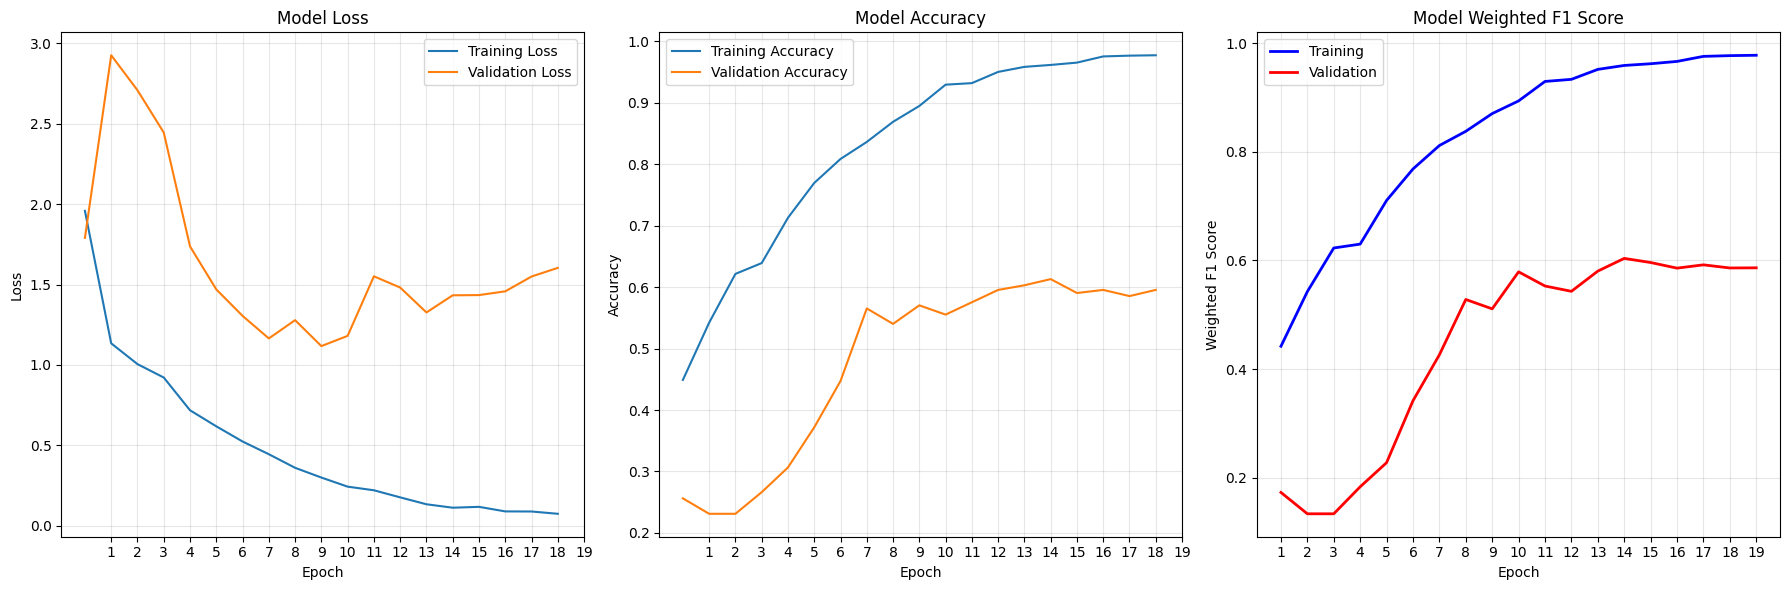


Results:
Validation Accuracy: 0.5955
Training Weighted F1 Score: 0.9778
Validation Weighted F1 Score: 0.5865


In [30]:
with open('histories/history0.json', 'r') as f:
    history = json.load(f)
plot_training_history(history)

The model is overfitting to the data quite a bit, given by the divering loss values between training and validation. I started by experimenting with the dropout values.

### Dropout

In [ ]:
model = Sequential([
    Conv2D(16, (5, 5), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(4, 4),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=METRICS
)

history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
).history

hists.append(history)
plot_training_history(history)

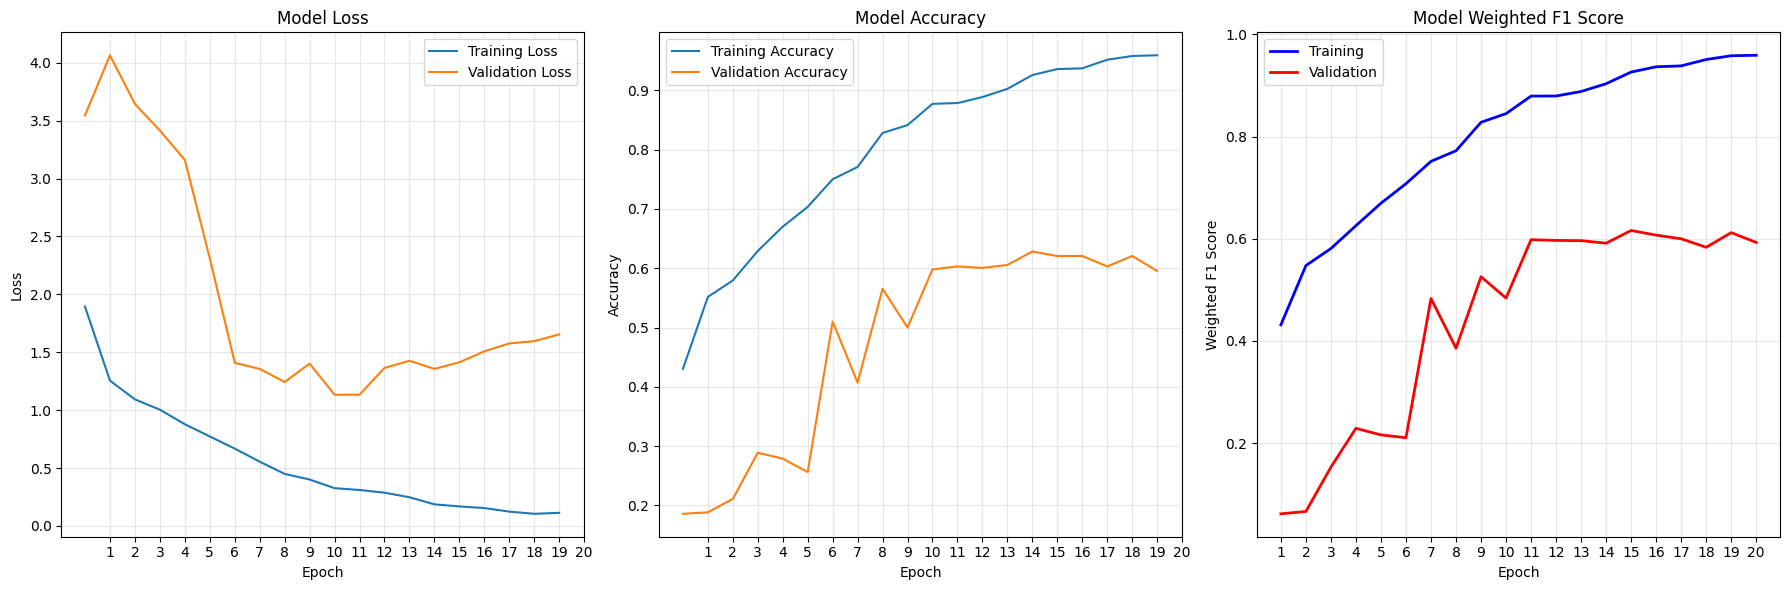


Results:
Validation Accuracy: 0.5955
Training Weighted F1 Score: 0.9592
Validation Weighted F1 Score: 0.5928


In [31]:
with open('histories/history1.json', 'r') as f:
    history = json.load(f)
plot_training_history(history)

In [ ]:
model = Sequential([
    Conv2D(16, (5, 5), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(4, 4),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=METRICS
)

history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
).history

hists.append(history)
plot_training_history(history)

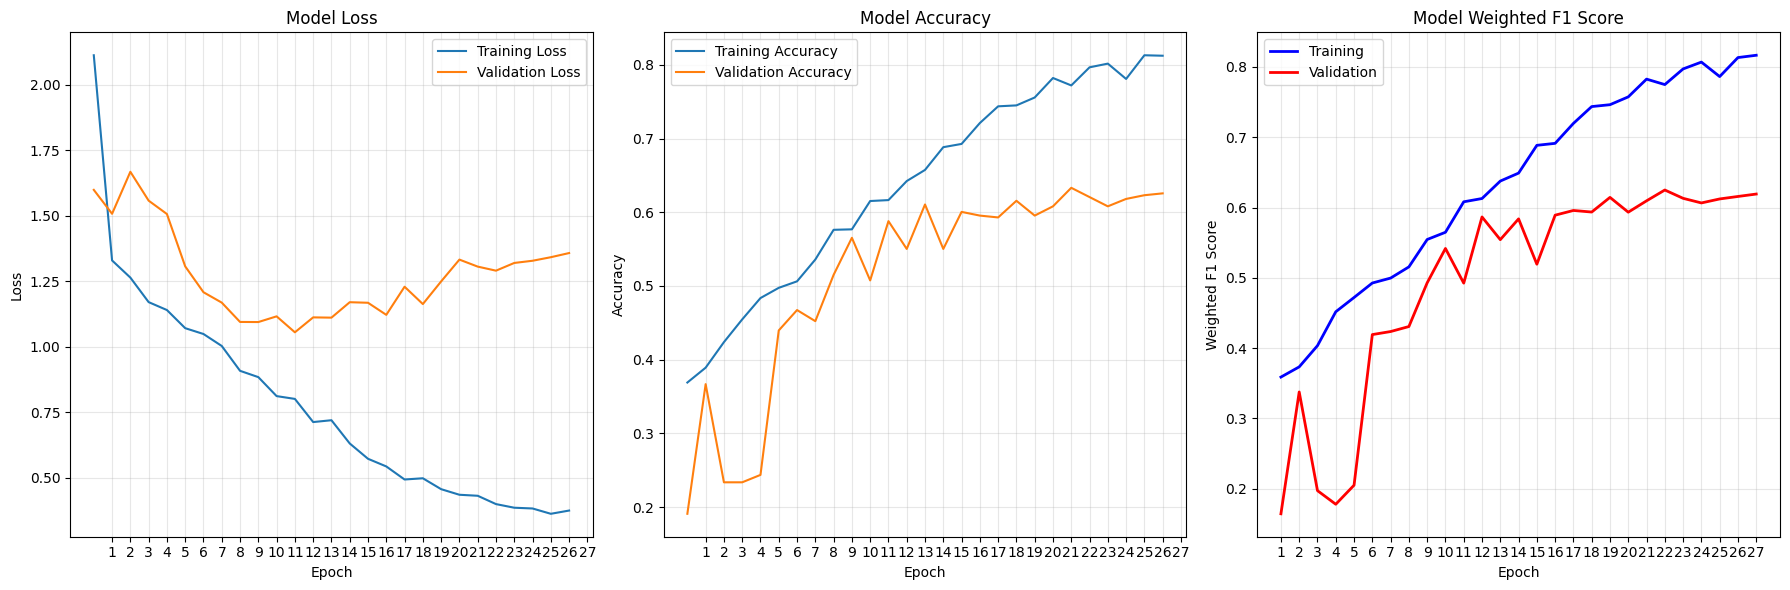


Results:
Validation Accuracy: 0.6256
Training Weighted F1 Score: 0.8167
Validation Weighted F1 Score: 0.6193


In [32]:
with open('histories/history2.json', 'r') as f:
    history = json.load(f)
plot_training_history(history)

The higher dropout clearly helped the model's validation and training scores become closer than before, so I kept the higher dropout value.

This is likely because the data was overfitting to too many unique aspects of the dataset, and thus needed to dropout many of the nodes from the dense layer in order to be more general.

### Batch Size

I then adjusted the batch size to see how it affected the performance.

In [ ]:
BATCH_SIZE = 64

train_data = (train_dataset
              .map(load_image_with_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .shuffle(BUFFER_SIZE)
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))

val_data = (val_dataset
            .map(load_image_with_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

train_data = train_data.map(convert_to_categorical)
val_data = val_data.map(convert_to_categorical)

model = Sequential([
    Conv2D(16, (5, 5), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(4, 4),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=METRICS
)

history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
).history

hists.append(history)
plot_training_history(history)

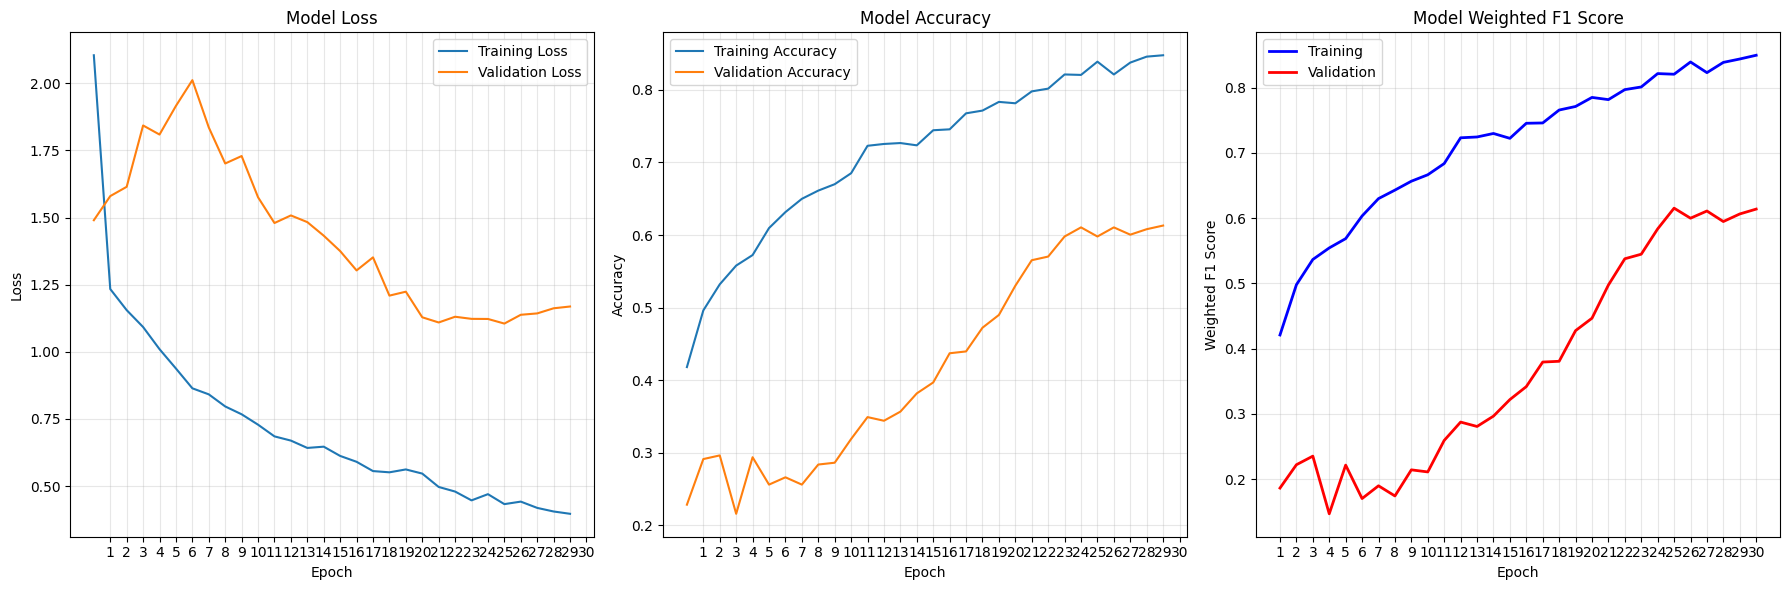


Results:
Validation Accuracy: 0.6131
Training Weighted F1 Score: 0.8495
Validation Weighted F1 Score: 0.6137


In [33]:
with open('histories/history3.json', 'r') as f:
    history = json.load(f)
plot_training_history(history)

In [ ]:
BATCH_SIZE = 128
train_data = (train_dataset
              .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .shuffle(BUFFER_SIZE)
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))

val_data = (val_dataset
            .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

train_data = train_data.map(convert_to_categorical)
val_data = val_data.map(convert_to_categorical)

model = Sequential([
    Conv2D(16, (5, 5), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(4, 4),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=METRICS
)

history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
).history

hists.append(history)
plot_training_history(history)

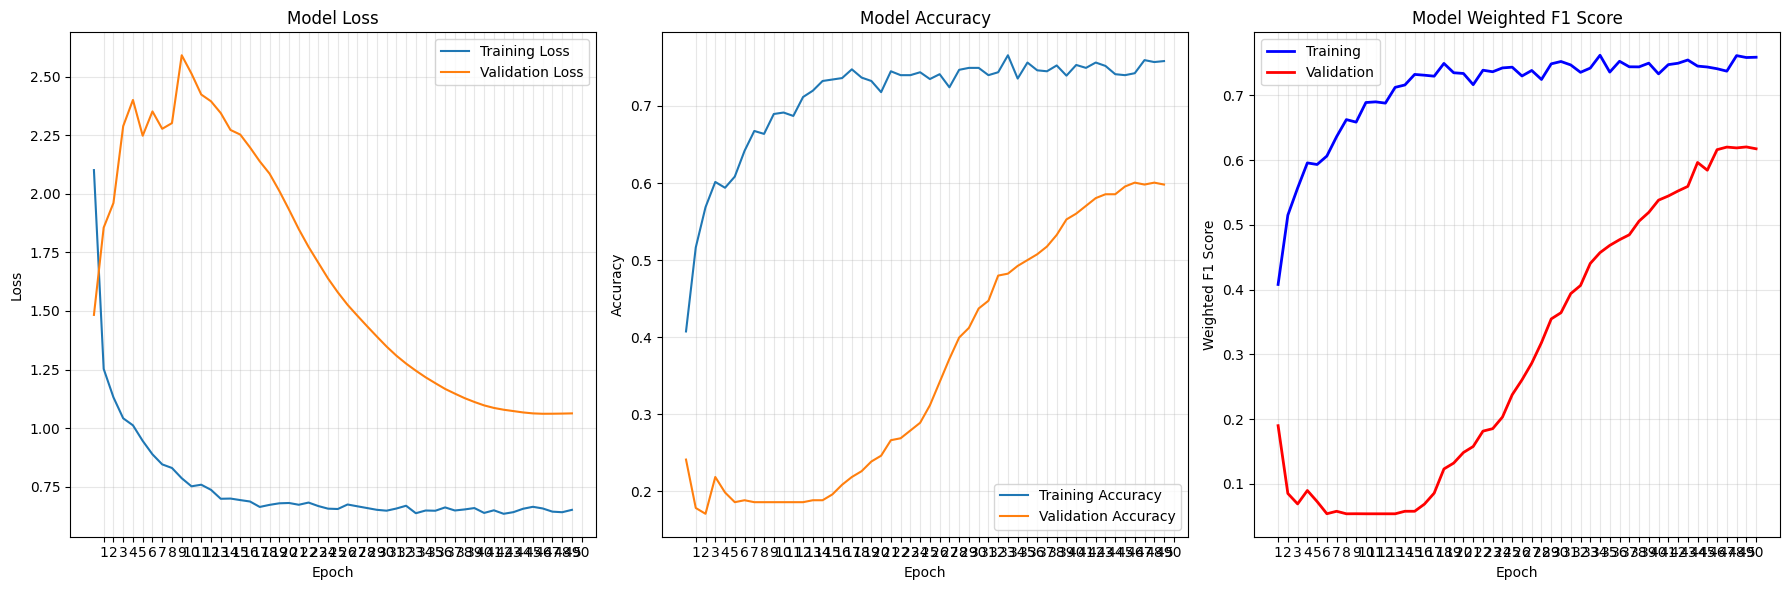


Results:
Validation Accuracy: 0.5980
Training Weighted F1 Score: 0.7587
Validation Weighted F1 Score: 0.6174


In [34]:
with open('histories/history4.json', 'r') as f:
    history = json.load(f)
plot_training_history(history)

The higher batch sizes helped the model converge more smoothly. This is likely because higher batch sizes allow the gradient update steps to have more information, and thus be more stable. Too large batch sizes can prevent the model from learning quick enough.

I ended up keeping the medium batch size of 64.

### Filters and Maxpool

I then adjusted the Maxpool layer sizes and the filter counts in the convolution layers.

In [ ]:
BATCH_SIZE = 64

train_data = (train_dataset
              .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .shuffle(BUFFER_SIZE)
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))

val_data = (val_dataset
            .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

train_data = train_data.map(convert_to_categorical)
val_data = val_data.map(convert_to_categorical)

model = Sequential([
    Conv2D(16, (5, 5), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=METRICS
)

history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
).history

hists.append(history)
plot_training_history(history)

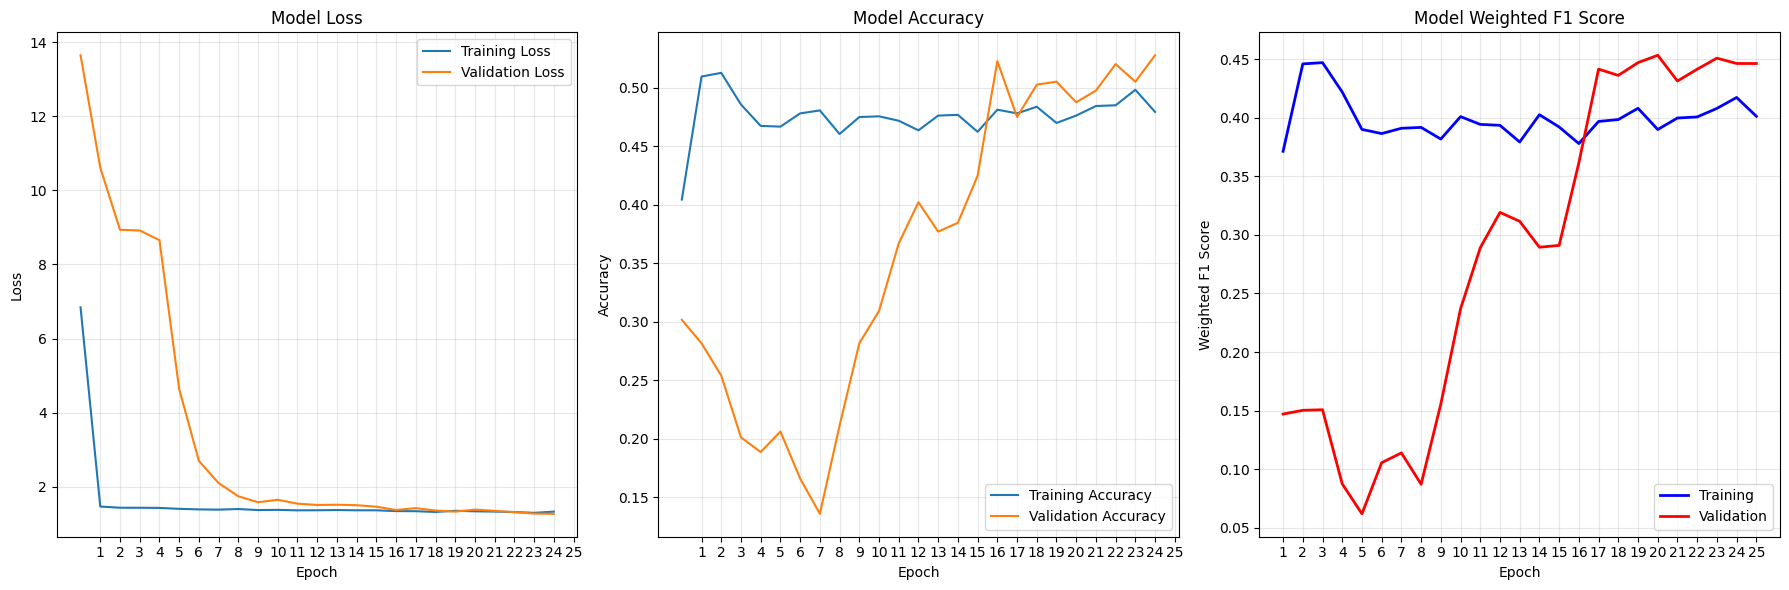


Results:
Validation Accuracy: 0.5276
Training Weighted F1 Score: 0.4013
Validation Weighted F1 Score: 0.4463


In [35]:
with open('histories/history5.json', 'r') as f:
    history = json.load(f)
plot_training_history(history)

Reducing the Maxpool layer's size had a mixed effect on the model. While it made the training and validation scores much closer to each other (indicating less overfitting), the overall accuracy and weighted f1 scores went down significantly.

In [ ]:
model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(4, 4),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=METRICS
)

history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
).history

hists.append(history)
plot_training_history(history)

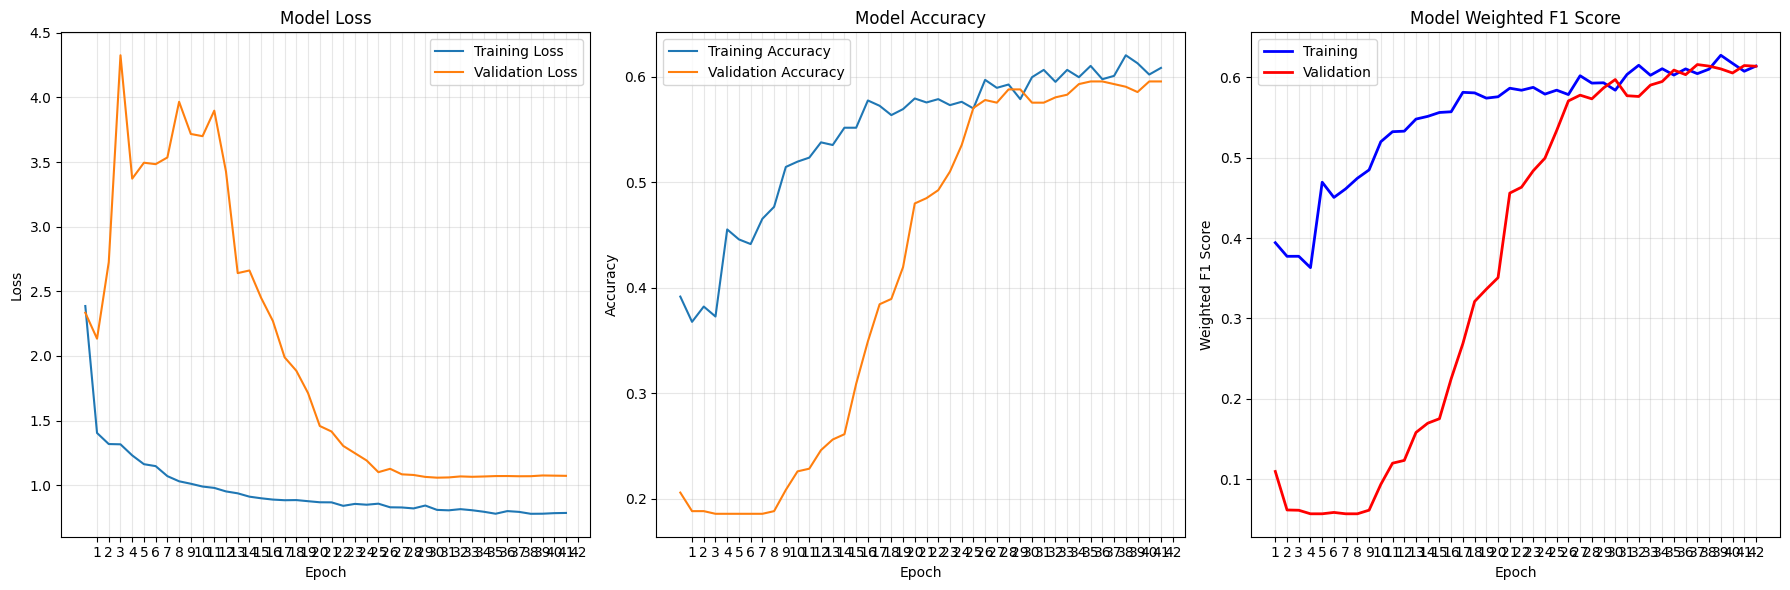


Results:
Validation Accuracy: 0.5955
Training Weighted F1 Score: 0.6141
Validation Weighted F1 Score: 0.6139


In [36]:
with open('histories/history6.json', 'r') as f:
    history = json.load(f)
plot_training_history(history)

Increasing the filter counts in each convolution layer had a similar effect on overfitting, while also increasing the final metrics. This is likely because higher filter counts allow the model to learn more detailed and broader patterns in the data, by processing each section more. I kept the higher filter counts.

### Architecture

I experimented with a more complex architecture. I added another convolution layer and another dense layer, significantly increasing the number of filters and trainable parameters.

In [38]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=METRICS
)

# Display model summary
model.summary()

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,213,573 (100.00 MB)

 Trainable params: 26,212,613 (99.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
).history

hists.append(history)
plot_training_history(history)

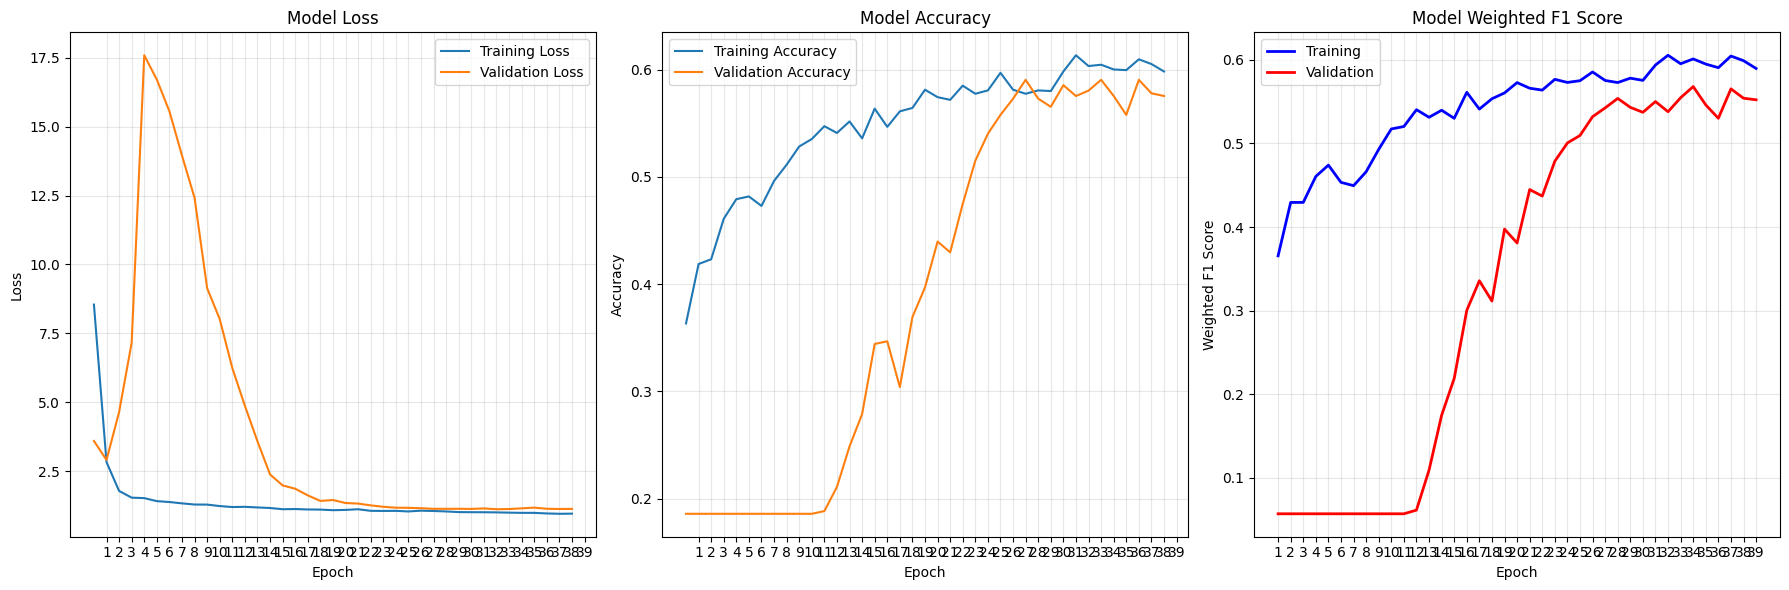


Results:
Validation Accuracy: 0.5754
Training Weighted F1 Score: 0.5897
Validation Weighted F1 Score: 0.5522


In [37]:
with open('histories/history7.json', 'r') as f:
    history = json.load(f)
plot_training_history(history)

Ultimately, this did not increase the final scores very much, but did have a positive effect on the overfitting problem. This is likely because while making the model more general, the model ends up not learning enough of this dataset to have as good scores.

***
# Results and Conclusions
***

### Results

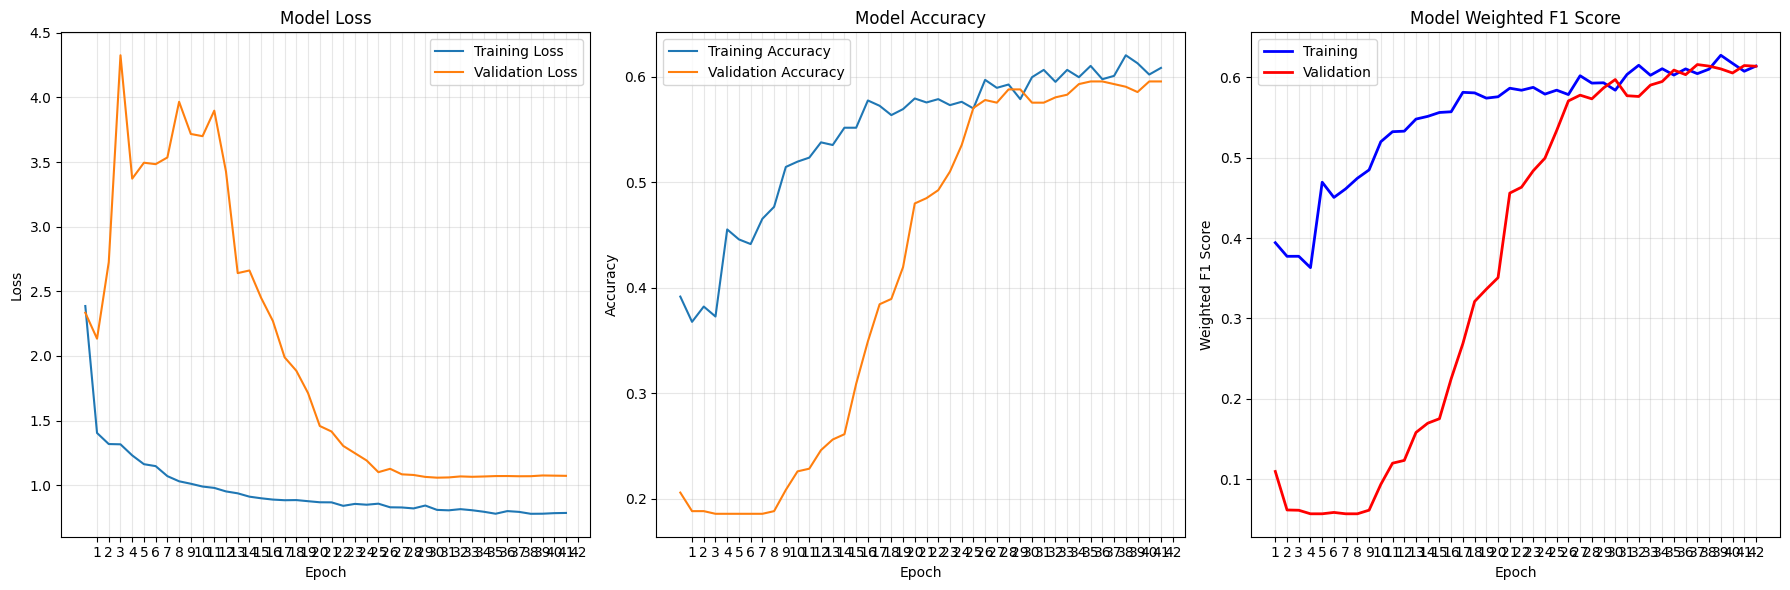


Results:
Validation Accuracy: 0.5955
Training Weighted F1 Score: 0.6141
Validation Weighted F1 Score: 0.6139


In [39]:
with open('histories/history6.json', 'r') as f:
    history = json.load(f)
plot_training_history(history)

My best model used the simpler architecture, a higher filter count, medium batch size, and higher maxpool count. The final accuracy was 59.5%, with a weighted F1 score of 0.6139.

### Hyperparameter Optimization Summary

My approach for tuning the hyperparameters involved taking each one, individually tuning it, and then moving on to the next with the best version of the model so far.

The learning rate was automatically tuned by the learning rate scheduler, which decreased the learning rate as the metrics for the model plateaued. I started with a slightly higher learning rate because of this.

I then tuned the dropout amounts, batch size, filter counts, max pool counts, and architecture individually.

Higher dropout amounts helped with the overfitting problem by reducing the amount of weights that passed to the final output layer. Higher batch sizes helped the model learn more stably, by using more samples per update step. Higher filter counts helped the model learn more detailed and broad patterns in the images.

Changing the max pool counts did not improve the performance much, but did help with the overfitting problem. Making the architecture more complex also similarly decreased overall performance, but reduced overfitting.

### Conclusion, Takeaways, and Further Steps

Ultimately, my model got a decent F1 score of 0.6139. While this may not be super accurate, it could still help medical professionals make a more informed decision, without relying completely on this model.

Through this project, I learned how different hyperparameters can affect the training process. I especially learned how data augmentation can help change the results significantly.

I tried some other experimentation with data augmentation to increase the size of the dataset, but they ultimately didn't end up improving the performance. This may be because the data, being images, could not be randomly generated. Other kinds of numerical data can be somewhat randomly generated with a specific distribution, but these images are very specific, and only small augmentations could be applied to it.

If I had more time, I would expand on the data augmentation process to fix what I was doing wrong with increasing the data set size. I would also do a more exhaustive grid search of hyperparameters, as well as try more complex architectures.

### References

> Kaggle dataset: https://www.kaggle.com/datasets/jockeroika/diabetic-retinopathy/data?select=Healthy

*AI Use/Citation:*

Github Copilot (Claude) was used during the development of this project. It's use was limited to:
- syntax correction/improvement
- code suggestions for small operations
- improving formatting of code
- nicely formatting print statements and statistics
- suggesting certain functions for plots I was trying to make
- making plots look and scale better

All ideas for every step of the project came from me.